In [40]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

{'cpu': 125.15761604309083, 'gpu': 69.19827160835266}


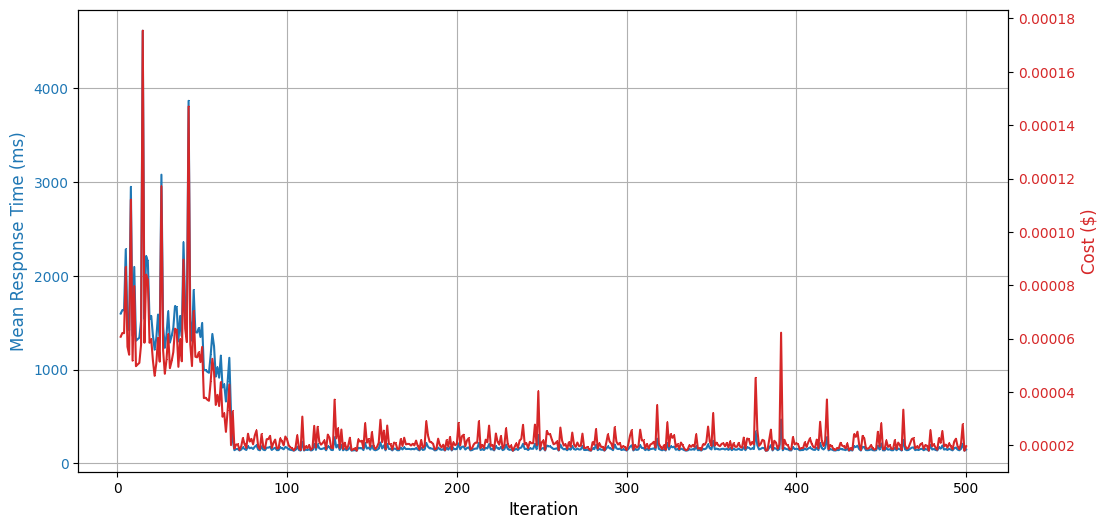

In [49]:
csv_files_auto = glob.glob("./data/auto/*response_times.csv")

dfs = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_auto]

combined_auto = pd.concat(dfs, axis=1)
combined_auto.columns = [f"run_{i + 1}" for i in range(len(dfs))]

combined_auto.head()

row_means = pd.DataFrame({
    "iteration": range(1, len(combined_auto) + 1),
    "mean_response_time": combined_auto.mean(axis=1).values
})

row_means["response_time_s"] = row_means["mean_response_time"] / 1000

# determine execution type
row_means["execution_type"] = row_means["response_time_s"].apply(
    lambda x: "cpu" if x > 0.5 else "gpu"
)

auto_run_times = row_means.groupby("execution_type")["response_time_s"].sum().to_dict()
print(auto_run_times)

# remove first row (cold start) for better visualization
row_means = row_means.iloc[1:]

# assign rates
cpu_rate = 0.000038  # per second
gpu_rate = 0.000133  # per second

# calculate cost
row_means["cost"] = row_means.apply(
    lambda row: row["response_time_s"] * (cpu_rate if row["execution_type"] == "cpu" else gpu_rate),
    axis=1
)

# plot with iteration on x axis and mean_response_time on y axis
# First y-axis: response time
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(row_means["iteration"], row_means["mean_response_time"], color="tab:blue", marker=',')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Mean Response Time (ms)", fontsize=12, color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

# Second y-axis: cost
ax2 = ax1.twinx()
ax2.plot(row_means["iteration"], row_means["cost"], color="tab:red", marker=',')
ax2.set_ylabel("Cost ($)", fontsize=12, color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.show()


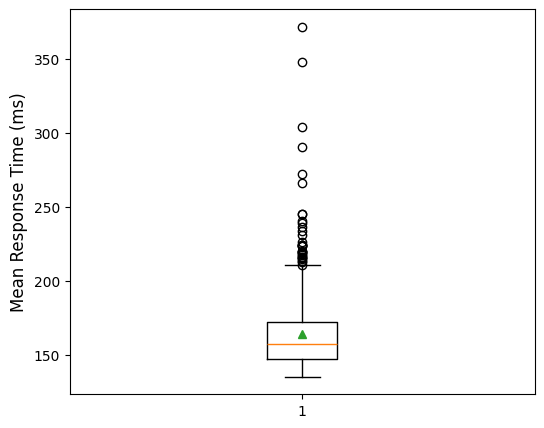

In [42]:
# GPU Boxplot
csv_files_gpu = glob.glob("./data/gpu/*response_times.csv")

dfs = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_gpu]

combined_gpu = pd.concat(dfs, axis=1)
combined_gpu.columns = [f"run_{i + 1}" for i in range(len(dfs))]

response_time_sum_gpu = combined_gpu.mean(axis=1).sum() / 1000

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_gpu = combined_gpu.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_gpu, showmeans=True)

# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

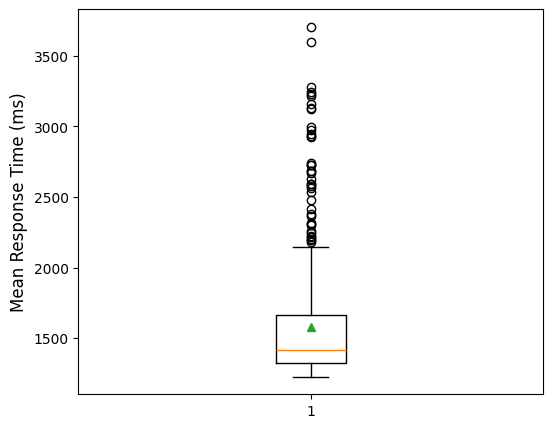

In [43]:
# CPU Boxplot
csv_files_cpu = glob.glob("./data/cpu/*response_times.csv")

dfs = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_cpu]

combined_cpu = pd.concat(dfs, axis=1)
combined_cpu.columns = [f"run_{i + 1}" for i in range(len(dfs))]

combined_cpu.head()

response_time_sum_cpu = combined_cpu.mean(axis=1).sum() / 1000

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_cpu = combined_cpu.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_cpu, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()


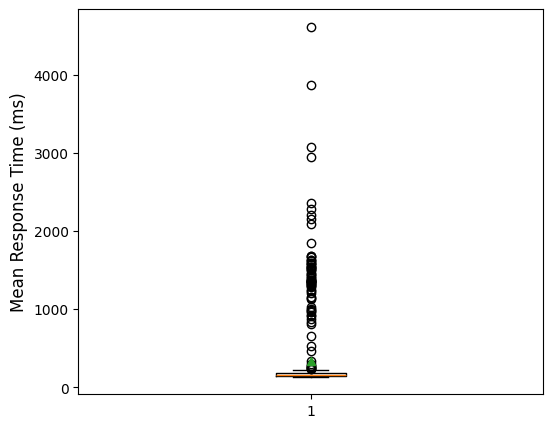

In [44]:
# Auto Boxplot
csv_files_auto = glob.glob("./data/auto/*response_times.csv")

dfs_auto = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_auto]

combined_auto = pd.concat(dfs_auto, axis=1)
combined_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

combined_auto.head()


# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_auto = combined_auto.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_auto, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

843.6487012863159
143.89957928657532
[np.float64(0.032058650648880006), np.float64(0.01913864404511452), 0.019089359533548355]


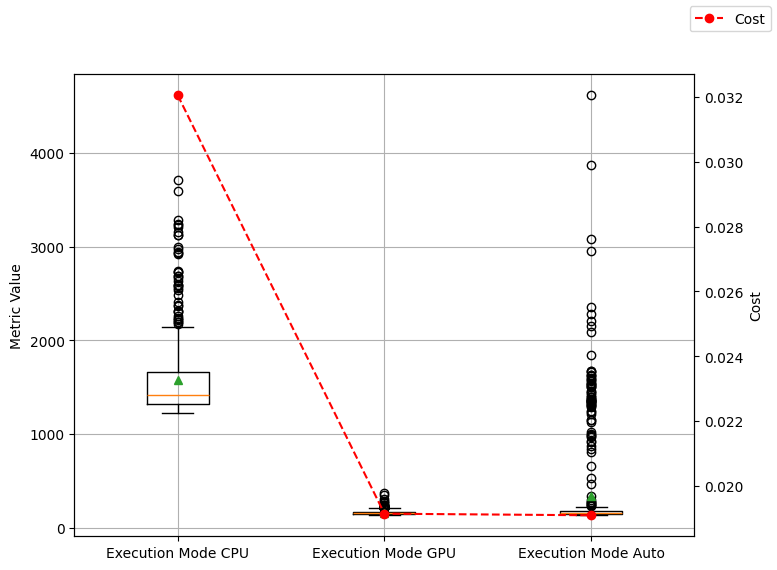

In [53]:
# Combine both CPU and GPU data for comparison

data = [row_means_without_coldstart_cpu, row_means_without_coldstart_gpu, row_means_without_coldstart_auto]

fig, ax1 = plt.subplots(figsize=(8,6))

# Boxplots on left y-axis
ax1.boxplot(
    data,
    tick_labels=["Execution Mode CPU", "Execution Mode GPU", "Execution Mode Auto"],
    showmeans=True
)
ax1.set_ylabel("Metric Value")

# I added 30s after experiment end to account the knative reconciliation time
cpu_seconds = 840.4 # 843
gpu_seconds = 144.6

cpu_seconds = response_time_sum_cpu + 30
gpu_seconds = response_time_sum_gpu + 30

print(cpu_seconds)
print(gpu_seconds)


auto_gpu_seconds = auto_run_times.get("gpu") + 30
auto_cpu_seconds = auto_run_times.get("cpu") + 30



costs = [cpu_seconds*cpu_rate, gpu_seconds*gpu_rate, auto_gpu_seconds*gpu_rate + auto_cpu_seconds*cpu_rate]

print(costs)

positions = [1, 2, 3]


# Add a second axis for costs
ax2 = ax1.twinx()
# positions = [1, 2, 3]
ax2.plot(positions, costs, "ro--", label="Cost")  # red dotted line with markers
ax2.set_ylabel("Cost")

ax1.grid(True)
fig.legend()
plt.show()


In [46]:
# Calculate and print summary statistics

# mean of first values
auto_coldstart = combined_auto.iloc[0].mean()
gpu_coldstart = combined_gpu.iloc[0].mean()
cpu_coldstart = combined_cpu.iloc[0].mean()


print(f"Auto Cold Start Mean: {auto_coldstart:.2f} ms")
print(f"GPU Cold Start Mean: {gpu_coldstart:.2f} ms")
print(f"CPU Cold Start Mean: {cpu_coldstart:.2f} ms")

Auto Cold Start Mean: 24471.46 ms
GPU Cold Start Mean: 31869.98 ms
CPU Cold Start Mean: 26523.70 ms
